In [56]:
# Instalar las librerías correspondientes para correr el proyecto
# pip install numpy scipy matplotlib seaborn scikit-learn mesa==3.0 -q

# Sistema de Recolección de Alimentos O(1)

## Objetivo del Sistema: 
Desarrollar un sistema donde agentes llamados 'exploradores' buscan comida y la llevan de vuelta a su base. Los exploradores se desplazan buscando celdas con alimentos y regresan a la base una vez que encuentran un recurso.

## Características del Sistema:
- Energia del Explorador: Cada explorador comienza con una energía máxima de X unidades, y cada movimiento consume 1 unidad de energía. Al llegar a la base, el explorador recarga completamente su energía.

- Ubicación de la Base: La base siempre se encuentra en el centro del área de búsqueda.

- Parámetros del Sistema:   
Un área de NxN celdas.  
Un número específico de exploradores.  
Una base fija en una celda determinada.  
Un número de recursos.  
Un máximo de energía que los exploradores pueden tener.  

## Distribución de Agentes y Recursos  
Tanto los agentes como los recursos se distribuyen aleatoriamente al inicio de la simulación.  

## Comportamiento por Paso:  
- Si la celda contiene recursos, el agente los recoge y regresa a la base.  
- Si la celda no contiene recursos, el agente elige una dirección aleatoria para moverse (una de las 4 celdas vecinas) a una celda sin otro agente. Si no puede moverse allí, permanecerá en la misma celda.  

## Instrucciones para la Simulación y el Análisis
1. Simulacion inicial:  
- Ejecuta una simulación para una matriz de 11x11 con 5 exploradores y 20 recursos.  
- Todos los agentes deben empezar con 100 unidades de energía.  
- Muestra gráficamente el comportamiento del modelo.  
- Recupera, y muestra, los siguiente datos de tu simulación:  
número de pasos necesarios para recolectar todos los recursos  
cuántos recursos recuperó cada agente  
cuántas recargar totales tuvo que hacer cada agente  

## Imports

----------------------------------------------

In [57]:
# Import las librerías necesarias
from mesa import Agent, Model
from mesa.space import SingleGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
#import pandas as pd

#import time
#import datetime

In [58]:
# -----------------------------------------------------
# Clase que representa a los agente que buscarán comida
# -----------------------------------------------------

class FoodExplorerAgent(Agent):
    # ------------------------------------------------
    # Constructor
    # ------------------------------------------------
    def __init__(self, model, _energy, agent_id):
        super().__init__(model)
        self.visited_cells = 1
        self.total_recharges = 0 
        self.resource_obtained = 0
        self.max_energy = _energy
        self.energy = _energy
        self.returning_base = False
        self.agent_id = agent_id

    # ------------------------------------------------
    # Método que devuelve al agente a la base, evitando
    # obstáculos
    # ------------------------------------------------
    def move_to_base(self):
        best_pos = None

        if self.pos[0] > self.model.base_coord[0]:
            best_pos = (self.pos[0]-1, self.pos[1])
        elif self.pos[0] < self.model.base_coord[0]:
            best_pos = (self.pos[0]+1, self.pos[1])
        elif self.pos[1] > self.model.base_coord[1]:
            best_pos = (self.pos[0], self.pos[1]-1)
        else:
            best_pos = (self.pos[0], self.pos[1]+1)

        if not self.model.grid.is_cell_empty(best_pos):
            return
        else:
            self.model.grid.move_agent(self, best_pos)
            self.visited_cells += 1
            self.energy -= 1
        self.returning_base = True
        
    # ------------------------------------------------
    # Método que mueve al agente a una posición
    # adyacente de manera aleatoria, evitando otros
    # agentes 
    # ------------------------------------------------
    def move(self):
        possible_positions = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        #print("Poss: ", possible_positions)
        base_x, base_y = self.model.base_coord
        dist = abs(self.pos[0] - base_x) + abs(self.pos[1] - base_y)

        options = np.random.permutation(len(possible_positions))

        if self.energy == dist:
            self.move_to_base()
        else: 
            for i in options:
                new_pos = possible_positions[i]
                if self.model.grid.is_cell_empty(new_pos) and new_pos != self.model.base_coord:
                    self.model.grid.move_agent(self, new_pos)
                    self.visited_cells += 1
                    self.energy -= 1
                    break
    # ------------------------------------------------
    # Método que avanza al agente un paso
    # ------------------------------------------------
    def step(self):
        (x,y) = self.pos
        #print("Pos: ", self.pos)
        if self.pos == self.model.base_coord and self.energy < self.max_energy:
            self.energy = self.max_energy
            self.total_recharges += 1
            self.returning_base = False
        if self.model.cells[x][y] == 1 and self.returning_base == False:  # encontró comida
            self.resource_obtained += 1
            self.model.cells[x][y] = 0
            self.returning_base = True
            self.model.num_food -= 1
        elif self.returning_base:
            self.move_to_base()
        #elif self.model.num_food: #> 0:
        else:
            self.move()

In [59]:
# ------------------------------------------------
# Función que devuelve la cuadrícula del modelo
# ------------------------------------------------
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for content, (x,y) in model.grid.coord_iter():
        grid[x][y] = model.cells[x][y]  # se obtiene el estado de la celda
        if content != None:
            grid[x][y] = 2 # El 2 indica el color más oscuro (robot), 
                        # 1 un gris (sucio) y el 0 un blanco (limpio)
    bx, by = model.base_coord
    grid[bx][by] = 3
    return grid

In [60]:
# -----------------------------------------------------
# Clase que representa al modelo, yo lo relaciono con
# el tablero, esta clase es la que contiene la lógica 
# de la simulación
# -----------------------------------------------------
class FoodExplorerModel(Model):
    # ------------------------------------------------
    # Constructor
    # ------------------------------------------------
    def __init__ (self, width, height, num_agents, num_food, energy, base_coord):
        super().__init__()
        self.num_agents = num_agents
        self.num_food = num_food
        self.base_coord = base_coord
        self.width = width
        self.height = height    
        
        self.grid = SingleGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)

        self.cells = np.zeros( (width, height))
        count = num_food  # Aquí se define la cantidad de comida a generar
        while count > 0:
        
            x = self.random.randrange(width)
            y = self.random.randrange(height)

            if self.cells[x][y] == 0 and (x, y) != self.base_coord:
                self.cells[x][y] = 1
                count -= 1

        #Crear agentes
        i = 0
        while i < num_agents:
            x = self.random.randrange(width)
            y = self.random.randrange(height)
        
            if self.grid.is_cell_empty((x,y)):
                agent = FoodExplorerAgent(self, energy, i+1)
                self.schedule.add(agent)
                self.grid.place_agent(agent, (x,y))
                i += 1

        self.steps = 0
        self.datacollector = DataCollector(
        model_reporters=
            {
                "Grid" : get_grid,
                "Steps" : lambda model : model.steps,
                "Clean" : lambda model : 1 - (model.cells.sum() / model.cells.size)             
            },
        )
    # ------------------------------------------------
    # Método que avanza un paso en la simulación
    # ------------------------------------------------
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.steps += 1

In [61]:
# ------------------------------------------------
# Parámetros de la simulación
# ------------------------------------------------
WIDTH = 11
HEIGHT = 11
AGENTS = 5
FOOD = 20
ENERGY = 100
BASE_COORD = (WIDTH // 2, HEIGHT // 2)
ITERATIONS = 1000

# ------------------------------------------------
# Creación del modelo
# ------------------------------------------------
model = FoodExplorerModel(WIDTH, HEIGHT, AGENTS, FOOD, ENERGY, BASE_COORD)
aux = 0

# ------------------------------------------------
# Ciclo for que lanza la simulación
# ------------------------------------------------
for i in range(ITERATIONS):
    model.step()
    if model.num_food == 0:
        aux += 1
        if aux >= WIDTH:
            aux2 = i+1
            break

# ------------------------------------------------
# Imprime la información requerida
# ------------------------------------------------
print()
for agent in model.schedule.agents:
    print(f"Agent {agent.unique_id} -> "
          f"Food: {agent.resource_obtained}, "
          f"Recharges: {agent.total_recharges}, "
          f"Cells visited: {agent.visited_cells}")
total_steps = 0
for agent in model.schedule.agents:
    total_steps += agent.visited_cells

print("\nTotal steps taken by all agents:", total_steps,"\n")


Agent 3 -> Food: 4, Recharges: 9, Cells visited: 704
Agent 5 -> Food: 3, Recharges: 9, Cells visited: 704
Agent 4 -> Food: 5, Recharges: 10, Cells visited: 706
Agent 2 -> Food: 1, Recharges: 7, Cells visited: 705
Agent 1 -> Food: 7, Recharges: 12, Cells visited: 697

Total steps taken by all agents: 3516 



C:\Users\aleja\AppData\Local\Temp\ipykernel_8160\3427166398.py:19: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in a future version. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


In [62]:
# ------------------------------------------------
# Obtiene las variables de model_reporters y las 
# imprime en formato de tabla
# ------------------------------------------------
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.head()

,Grid,Steps,Clean
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",1,0.834711
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",3,0.842975
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",5,0.842975
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",7,0.842975
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",9,0.851240


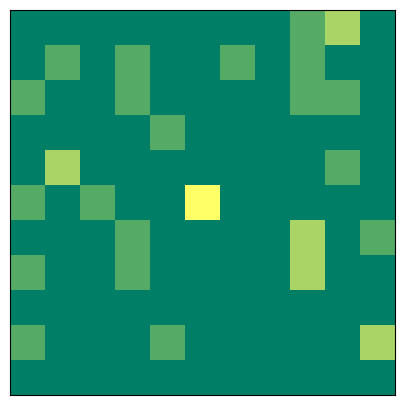

In [63]:
# ------------------------------------------------
# Genera una simulación en matplolib donde se va 
# actualizando la cuadrícula del modelo
# ------------------------------------------------
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grids.iloc[0,0], cmap=plt.cm.summer)
def animate(i):
    patch.set_data(all_grids.iloc[i,0])

anim = animation.FuncAnimation(fig, animate,frames=aux2)

In [64]:
# ------------------------------------------------
# Llama a la variable anim para que se muestre la 
# animación
# ------------------------------------------------
anim